### Clone repo

In [14]:
!git clone https://github.com/lamnguyenvu98/unsupervised-anomaly-detection.git

Cloning into 'unsupervised-anomaly-detection'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 205 (delta 96), reused 167 (delta 61), pack-reused 0
Receiving objects: 100% (205/205), 6.86 MiB | 25.64 MiB/s, done.
Resolving deltas: 100% (96/96), done.


## Setup kaggle

Upload `kaggle.json` to GDrive

In [2]:
%%writefile /content/kaggle.sh
#!/bin/bash
if [ ! -d "/root/.kaggle" ]
then
  mkdir /root/.kaggle
fi

sudo cp /content/drive/MyDrive/kaggle.json  /root/.kaggle/kaggle.json
chmod 600 /root/.kaggle/kaggle.json

Writing /content/kaggle.sh


## Install transistor dataset

*Note*: transistor dataset is a subset of mvtec-ad dataset

**Explain dataset structure:**


Here, we download 2 datasets: MVTec-AD (contains many different objects) and Transistor dataset for testing purpose

Transistor dataset should be replaced by your custom dataset.

Your custom dataset should have the following order:

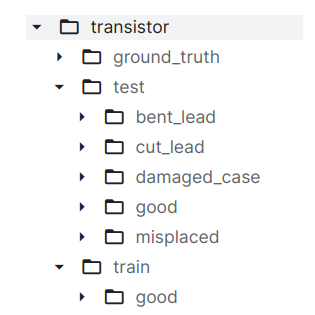

In the example above, transistor is the dataset root. It will contain a train folder and a test folder.

In the train folder, it only contains a `good` folder. `good` folder contains normal images (OK).

In the test folder, it contains good and other anomaly folders. Since, we don't care about these anomaly classes. We can specify only a anomaly folder, or whatever the name that you want. In short, test will contain `good` and `anomaly` folder. Inside of good, there are normal images. Inside of anomaly folder, there are abnormal (NG) images.

In [ ]:
### Mvtech
%%capture
!bash /content/kaggle.sh
!kaggle datasets download -d ipythonx/mvtec-ad
!mkdir /content/mvtec-ad
!unzip /content/mvtec-ad.zip -d /content/mvtec-ad
!rm /content/mvtec-ad.zip

## Install project and dependencies

Overwriting `pyproject.toml`. This new file only requires 2 dependencies: "kornia" and "dotmap", other packages are already available in Colab.

This file won't work if you run in virtual environment in local machine. In that case, you use the default one.

In [15]:
%cd /content/unsupervised-anomaly-detection

/content/unsupervised-anomaly-detection
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


In [16]:
%%writefile /content/unsupervised-anomaly-detection/pyproject.toml
[build-system]
requires = ["setuptools>=61.0", "setuptools-scm"]
build-backend = "setuptools.build_meta"

[project]
name = "Unsupervised-Anomaly-Detection"
version = "1.0.0"
authors = [
    {name = "Vu Lam Nguyen", email = "lamnguyenvu98@gmail.com"},
]
description = "Unsupervised Anomaly Detection"
requires-python = "==3.10.*"
dependencies = ["kornia==0.6.9", "dotmap==1.3.30"]

[tool.setuptools.packages.find]
where=["src"]

Overwriting /content/unsupervised-anomaly-detection/pyproject.toml


In [ ]:
!python -m pip install .

## Train padim and evaluate

In [18]:
%%writefile /content/padim_config.yaml
MODEL:
  INPUT_SIZE: 256
TRAIN:
  EPOCH: 50
  BATCH_SIZE: 8
  PRETRAINED: True
  DEVICE: "cuda"
  DATA_DIR: "/content/mvtec-ad/bottle"
  SAVE_DIR: "/content"
  CHECKPOINT_PATH: ""
  REDUCE_FEATURES: 100

Writing /content/padim_config.yaml


In [19]:
!python train/train_padim.py \
    --config /content/padim_config.yaml

Size of training set:  209
Size of testing set:  83
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 195MB/s]
Optimal threshold is: 0.31302464
ROC AUC score: 0.9952380952380953
Threshold:  0.31302464


## Train DFR

In [21]:
%%writefile /content/dfr_config.yaml
MODEL:
  INPUT_SIZE: 224
TRAIN:
  EPOCH: 700
  BURN_IN: 100
  BATCH_SIZE: 8
  LEARNING_RATE: 1.0e-4
  NUM_LAYERS: 16
  PRETRAINED: True
  DEVICE: "cuda"
  DATA_DIR: "/content/mvtec-ad/bottle"
  SAVE_DIR: "/content"
  RESUME_TRAIN: False
  CHECKPOINT_PATH: "/content/last.pt"

Overwriting /content/dfr_config.yaml


In [ ]:
!python train/train_dfr.py \
    --config /content/dfr_config.yaml

## Train RegAD

In [23]:
%%writefile /content/regad_config.yaml
MODEL:
  INPUT_SIZE: 224
  BACKBONE: "resnet18"
  STN_MODE: "rotation_scale"
TRAIN:
  EPOCH: 50
  BURN_IN: 2
  BATCH_SIZE: 32
  N_SHOT: 4
  N_TEST: 5
  LEARNING_RATE_STN: 1.0e-4
  LEARNING_RATE_ENC: 1.0e-4
  LEARNING_RATE_PRED: 1.0e-4
  MOMENTUM_STN: 9.0e-1
  MOMENTUM_ENC: 9.0e-1
  MOMENTUM_PRED: 9.0e-1
  PRETRAINED: True
  DEVICE: "cuda"
  TRAIN_DATA_DIR: "/content/mvtec-ad"
  TEST_DATA_DIR: "/content/mvtec-ad/bottle"
  IGNORE_CLASS: "bottle"
  SAVE_DIR: "/content"
  RESUME_TRAIN: False
  CHECKPOINT_PATH: "/content/last.pt"
INFERENCE:
  SUPPORT_SET_PATH: ""

Writing /content/regad_config.yaml


In [ ]:
!python train/train_regad.py \
    --config /content/regad_config.yaml